- 데이터 필터링은 charge session 단위가 아니라 'cid' 단위로 할것.
    - 동일 cid의 일부 charge session을 제외할 경우 시간순에 따라 windowing을 하여 피쳐를 생성하는 과정에서 왜곡이 발생함

In [1]:
import pandas as pd

pd.options.display.float_format = '{: .2f}'.format

In [2]:
# 가장 최근의 2021년 7월~ 12월 (6개월) 데이터 로드

df = pd.read_csv('../data/한국전력공사_전기차충전소충전량(202107_202112).csv', 
                 parse_dates=['충전종료일자', '충전시작시각', '충전종료시각'], 
                 encoding='cp949')

In [3]:
df.head()

,본부,사업소,충전소명,충전기,충전기ID,주소,충전기구분,충전용량,충전량,충전시간,충전분,충전종료일자,충전시작시각,충전종료시각
0,강원,강원직할,강원직할,완속05,1296,강원도 춘천시 수풍골길 7,완속,7.00,13.17,2,39,2021-07-01,2021-07-01 19:35:55,2021-07-01 22:15:42
1,남서울,남서울직할,남서울직할,급속01,8858,서울특별시 영등포구 여의도동 21,급속,50.00,15.84,0,24,2021-07-01,2021-07-01 14:30:46,2021-07-01 14:54:51
2,남서울,남서울직할,남서울직할,급속01,8858,서울특별시 영등포구 여의도동 21,급속,50.00,11.70,0,43,2021-07-01,2021-07-01 16:52:38,2021-07-01 17:36:36
3,강원,강원직할,강원직할,완속02,1293,강원도 춘천시 수풍골길 7,완속,7.00,5.40,1,23,2021-07-01,2021-07-01 10:58:58,2021-07-01 12:22:29
4,강원,강원직할,강원직할,완속02,1293,강원도 춘천시 수풍골길 7,완속,7.00,5.53,2,11,2021-07-01,2021-07-01 16:46:25,2021-07-01 18:58:12


In [4]:
drop_cols = ['본부', '사업소', '충전소명', '충전기', '주소', '충전종료일자']
rename_dict = {'충전기ID':'cid', '충전기구분':'charger_type', '충전용량':'charging_power', 
               '충전량':'charge_amount', '충전시간':'hour', '충전분':'minute',
               '충전시작시각':'start_time', '충전종료시각':'finish_time'}

# df = df.drop(drop_cols, axis=1)
df = df.rename(columns=rename_dict)
df = df.loc[df['charger_type'] == '급속']
df['duration'] = df.hour.multiply(60).add(df.minute)
df = df.drop(['charger_type', 'hour', 'minute'], axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583023 entries, 1 to 1048572
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   본부              583023 non-null  object        
 1   사업소             583023 non-null  object        
 2   충전소명            583023 non-null  object        
 3   충전기             583023 non-null  object        
 4   cid             583023 non-null  int64         
 5   주소              582745 non-null  object        
 6   charging_power  556320 non-null  float64       
 7   charge_amount   583023 non-null  float64       
 8   충전종료일자          583023 non-null  datetime64[ns]
 9   start_time      583023 non-null  datetime64[ns]
 10  finish_time     583023 non-null  datetime64[ns]
 11  duration        583023 non-null  int64         
dtypes: datetime64[ns](3), float64(2), int64(2), object(5)
memory usage: 57.8+ MB


In [6]:
# 8080개 device
df.cid.nunique()

8080

In [7]:
# 7~12월 간의 데이터이지만 실질적으로 10월 17일까지의 로그만 존재함
df.describe(datetime_is_numeric=True)

# 7~9의 3개월 데이터만 분리
df = df[df.start_time.between('2021-07-01', '2021-10-01')]
df.cid.nunique()

7723

In [8]:
# 실질적으로 활발히 운영되는 충전기로 한정하기 위하여, 분석기간(3개월) 내 첫주와 마지막주에 모두 충전시작이 있는 충전기로 제한

first_charge = df.groupby('cid')['start_time'].min()
valid_id_first = first_charge[first_charge < '2021-07-07'].index

last_charge = df.groupby('cid')['start_time'].max()
valid_id_last = last_charge[last_charge > '2021-09-23'].index

In [9]:
# 총 3,213개의 충전기
valid_cid = set(valid_id_first).intersection(valid_id_last)
len(valid_cid)

3213

In [10]:
# 총 충전의 90% 이상이며 3개월간 441,530건
df.cid.isin(valid_cid).mean(), df.cid.isin(valid_cid).sum()

(0.9060910215866905, 441530)

In [11]:
# valid_cid의 로그만 선택하여 charge 테이블 생성
charge = df[df.cid.isin(valid_cid)].copy()

In [12]:
charge.head()

,본부,사업소,충전소명,충전기,cid,주소,charging_power,charge_amount,충전종료일자,start_time,finish_time,duration
10,경기북부,양평,양평지사,급속02,8833,경기도 양평군 강상면 강남로 933,50.00,13.00,2021-07-01,2021-07-01 11:19:00,2021-07-01 11:41:11,22
11,경남,창녕,창녕지사,급속01,471,"경상남도 창녕군 창녕읍 남창녕로 71 (교하리, 한국전력공사 창녕지점)",50.00,27.05,2021-07-01,2021-07-01 07:26:01,2021-07-01 08:05:16,39
12,경남,창녕,창녕지사,급속01,471,"경상남도 창녕군 창녕읍 남창녕로 71 (교하리, 한국전력공사 창녕지점)",50.00,10.64,2021-07-01,2021-07-01 13:56:30,2021-07-01 14:17:05,20
24,경북,문경,문경지사,급속01,792,경상북도 문경시 모전로 75,50.00,36.35,2021-07-01,2021-07-01 01:50:09,2021-07-01 03:04:14,74
27,경기,경기직할,경기직할,급속02,879,경기도 수원시 팔달구 중부대로 120,50.00,7.69,2021-07-01,2021-07-01 07:14:24,2021-07-01 07:54:04,39


In [13]:
# charging_power에서 null 발생 ->  피쳐로 활용할 것 이므로 null row 제거
charge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 441530 entries, 10 to 899545
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   본부              441530 non-null  object        
 1   사업소             441530 non-null  object        
 2   충전소명            441530 non-null  object        
 3   충전기             441530 non-null  object        
 4   cid             441530 non-null  int64         
 5   주소              441422 non-null  object        
 6   charging_power  436187 non-null  float64       
 7   charge_amount   441530 non-null  float64       
 8   충전종료일자          441530 non-null  datetime64[ns]
 9   start_time      441530 non-null  datetime64[ns]
 10  finish_time     441530 non-null  datetime64[ns]
 11  duration        441530 non-null  int64         
dtypes: datetime64[ns](3), float64(2), int64(2), object(5)
memory usage: 43.8+ MB


In [14]:
power_null_ids = charge[charge.charging_power.isna()].cid.unique()
charge = charge[~charge.cid.isin(power_null_ids)]

In [15]:
charge.charging_power.unique()

array([ 50., 200., 100.])

### duration 이상치 필터링

In [16]:
charge.duration.describe()

count    436187.00
mean         51.09
std          83.39
min           0.00
25%          25.00
50%          42.00
75%          66.00
max       24369.00
Name: duration, dtype: float64

In [17]:
import numpy as np

def outlier_bound(array):
    stdev = np.std(array)
    med = np.median(array)
    return med - 3*stdev, med + 3*stdev

outlier_bound(charge.duration)

(-208.18165142488976, 292.18165142488976)

In [18]:
# 292분 초과하는 경우 1,915건으로 전체 중 0.4% 가량
charge.duration.gt(outlier_bound(charge.duration)[1]).sum(), charge.duration.gt(outlier_bound(charge.duration)[1]).mean()

(1915, 0.004390318831143524)

In [19]:
outlier_cid = charge[charge.duration.gt(outlier_bound(charge.duration)[1])].cid.unique()

In [20]:
charge = charge[~charge.cid.isin(outlier_cid)]

In [21]:
# 2453개의 cid
charge.cid.nunique()

2453

In [22]:
# 충전기당-일당 충전횟수는 최대 24.48회 최소 0.03회
charge.groupby('cid')['charging_power'].count().divide(92).describe()

count    2453.00
mean        1.58
std         1.84
min         0.03
25%         0.51
50%         1.03
75%         2.02
max        24.48
Name: charging_power, dtype: float64

<AxesSubplot: ylabel='Frequency'>

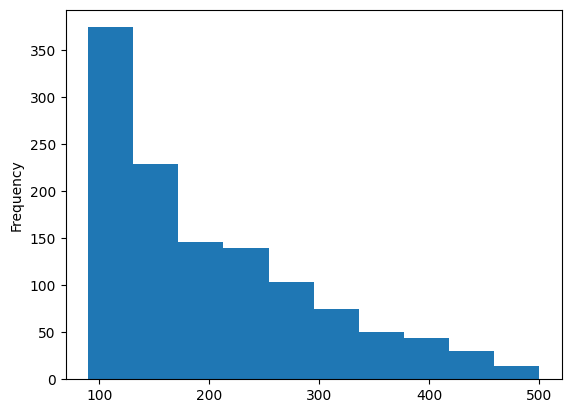

In [23]:
charge.groupby('cid')['charging_power'].count().plot(kind='hist', range=(90,500))

In [24]:
# 충전소명으로 집계 가능 확인 ->  cid가 여러 충전소명 가지고있는 경우 없음
n_office = charge.groupby('cid')['충전소명'].nunique()
n_office[n_office>1]

Series([], Name: 충전소명, dtype: int64)

In [25]:
charge.head()

,본부,사업소,충전소명,충전기,cid,주소,charging_power,charge_amount,충전종료일자,start_time,finish_time,duration
10,경기북부,양평,양평지사,급속02,8833,경기도 양평군 강상면 강남로 933,50.00,13.00,2021-07-01,2021-07-01 11:19:00,2021-07-01 11:41:11,22
11,경남,창녕,창녕지사,급속01,471,"경상남도 창녕군 창녕읍 남창녕로 71 (교하리, 한국전력공사 창녕지점)",50.00,27.05,2021-07-01,2021-07-01 07:26:01,2021-07-01 08:05:16,39
12,경남,창녕,창녕지사,급속01,471,"경상남도 창녕군 창녕읍 남창녕로 71 (교하리, 한국전력공사 창녕지점)",50.00,10.64,2021-07-01,2021-07-01 13:56:30,2021-07-01 14:17:05,20
24,경북,문경,문경지사,급속01,792,경상북도 문경시 모전로 75,50.00,36.35,2021-07-01,2021-07-01 01:50:09,2021-07-01 03:04:14,74
27,경기,경기직할,경기직할,급속02,879,경기도 수원시 팔달구 중부대로 120,50.00,7.69,2021-07-01,2021-07-01 07:14:24,2021-07-01 07:54:04,39


In [26]:
drop_cols = ['본부', '사업소','충전기', '주소', '충전종료일자']
charge = charge.drop(columns=drop_cols)

### start ->  finish 정보로 부터 step별 occupancy 여부 생성

In [27]:
from tqdm import tqdm
tqdm.pandas()

sample = charge.query("cid == 8833")

# 7,8,9월 31, 31, 30일
TIME_IDX = pd.date_range('2021-07-01', freq='10min', periods=(31+31+30)*24*6)
data = pd.Series(index=TIME_IDX, data=0)

result = np.full(TIME_IDX.shape[0], False)

for start_time, finish_time in tqdm((zip(sample.start_time, sample.finish_time))):
    occupied = (TIME_IDX >= start_time) & (TIME_IDX <= finish_time)
    result = result | occupied

pd.Series(data=result, index=TIME_IDX)

127it [00:00, 8822.65it/s]


2021-07-01 00:00:00    False
2021-07-01 00:10:00    False
2021-07-01 00:20:00    False
2021-07-01 00:30:00    False
2021-07-01 00:40:00    False
                       ...  
2021-09-30 23:10:00    False
2021-09-30 23:20:00    False
2021-09-30 23:30:00    False
2021-09-30 23:40:00    False
2021-09-30 23:50:00    False
Freq: 10T, Length: 13248, dtype: bool

In [28]:
from tqdm import tqdm
tqdm.pandas()


def check_occupancy(cid_df):
    TIME_IDX = pd.date_range('2021-07-01', freq='10min', periods=(31+31+30)*24*6)  # 7,8,9월 31, 31, 30일
    result = np.full(TIME_IDX.shape[0], False)

    for start_time, finish_time in zip(cid_df.start_time, cid_df.finish_time):
        occupied = (TIME_IDX >= start_time) & (TIME_IDX <= finish_time)
        result = result | occupied
    return pd.Series(data=result, index=TIME_IDX)

In [29]:
df = charge.groupby('cid')[['start_time', 'finish_time']].progress_apply(check_occupancy).astype(np.int32)

100%|██████████| 2453/2453 [00:37<00:00, 65.04it/s] 


In [30]:
station_history = df.reset_index().merge(charge[['cid', '충전소명']] \
   .drop_duplicates(), how='left', on='cid').drop(columns=['cid']) \
   .groupby('충전소명').all().astype(np.int32).T

In [31]:
station_history.head()

충전소명,(주)플러스 전용 전기버스 충전소,2생활권 환승주차장1(A),2호선 양산역,CGV 신대점,DMC아이파크 아파트,G-Tower(경제자유구역청),GS강동자이 아파트,HAPPY700 평창시네마,KBS 방송국,KBS전주총국,...,휘경베스트빌현대,휘경주공1단지,휴먼빌2단지 아파트,휴먼시아남춘천1단지,휴먼시아청계마을4단지,흑석한강센트레빌,흥덕힐스테이트 아파트,힐스테이트상도프레스티지,힐스테이트위례,힐스테이트황금산
2021-07-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-07-01 00:10:00,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2021-07-01 00:20:00,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2021-07-01 00:30:00,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2021-07-01 00:40:00,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [32]:
# occupancy rate가 높은 상위 100개 충전소 선택
occupancy_rate = station_history.mean().sort_values(ascending=False)
occupancy_rate

충전소명
첨단공용차고지            0.40
뚝도충전소              0.33
가락2동 주민센터          0.30
인천업사이클 에코센터        0.29
도봉구청               0.28
                   ... 
용산역 아이파크몰          0.00
삼성현역사문화공원 제2주차장    0.00
도산버스차고지            0.00
전쟁기념관              0.00
동부농업기술센타           0.00
Length: 2095, dtype: float64

In [33]:
station_samples = occupancy_rate[:100].index
modeling_history = station_history[station_samples]

In [34]:
modeling_history.head()

충전소명,첨단공용차고지,뚝도충전소,가락2동 주민센터,인천업사이클 에코센터,도봉구청,대전역사박물관,강남구청 공영주차장,교1동주민센터,금천구청 지상 주차장,관악동작 견인차량 보관소,...,홈플러스 내당점,남서울직할(영등포)지사,광진구청 주차장,성덕동주민센터,부주동 행정복지센터,천안지사(공용),양산웅상출장소,구래동 주민센터,사이동 커뮤니센터,LH강원본부
2021-07-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-07-01 00:10:00,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-07-01 00:20:00,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-07-01 00:30:00,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-07-01 00:40:00,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# 임베딩 레이어에 인풋으로 쓰기 위해 스테이션명 라벨 인코딩

station_encoder = {name:idx for idx, name in enumerate(modeling_history.columns)}

In [36]:
col_idx = 0
t = 12


history = modeling_history.iloc[t-11:t+1, col_idx].values
station_idx = station_encoder[modeling_history.columns[col_idx]]
label = modeling_history.iloc[t+6, col_idx]

print('history sequence: ', history)
print('station index: ', station_idx)
print('label (1hr prediction): ', label)

history sequence:  [0 0 0 0 0 0 0 0 0 0 0 0]
station index:  0
label (1hr prediction):  0


In [37]:
modeling_history.shape

(13248, 100)

In [38]:
modeling_history.reset_index()

충전소명,index,첨단공용차고지,뚝도충전소,가락2동 주민센터,인천업사이클 에코센터,도봉구청,대전역사박물관,강남구청 공영주차장,교1동주민센터,금천구청 지상 주차장,...,홈플러스 내당점,남서울직할(영등포)지사,광진구청 주차장,성덕동주민센터,부주동 행정복지센터,천안지사(공용),양산웅상출장소,구래동 주민센터,사이동 커뮤니센터,LH강원본부
0,2021-07-01 00:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-07-01 00:10:00,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-07-01 00:20:00,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-07-01 00:30:00,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-07-01 00:40:00,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13243,2021-09-30 23:10:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13244,2021-09-30 23:20:00,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
13245,2021-09-30 23:30:00,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
13246,2021-09-30 23:40:00,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
modeling_history.index

Index([2021-07-01 00:00:00, 2021-07-01 00:10:00, 2021-07-01 00:20:00,
       2021-07-01 00:30:00, 2021-07-01 00:40:00, 2021-07-01 00:50:00,
       2021-07-01 01:00:00, 2021-07-01 01:10:00, 2021-07-01 01:20:00,
       2021-07-01 01:30:00,
       ...
       2021-09-30 22:20:00, 2021-09-30 22:30:00, 2021-09-30 22:40:00,
       2021-09-30 22:50:00, 2021-09-30 23:00:00, 2021-09-30 23:10:00,
       2021-09-30 23:20:00, 2021-09-30 23:30:00, 2021-09-30 23:40:00,
       2021-09-30 23:50:00],
      dtype='object', length=13248)

In [40]:
from tqdm import tqdm

dataset = []

for col_idx in tqdm(range(modeling_history.shape[1])):
    for t in range(12,modeling_history.shape[0]-6):
        history = modeling_history.iloc[t-11:t+1, col_idx].values.tolist()
        station_idx = station_encoder[modeling_history.columns[col_idx]]
        date = modeling_history.index[t+6]
        label = modeling_history.iloc[t+6, col_idx]
        feature_row = history + [station_idx, date, label]
        dataset.append(feature_row)

100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


In [41]:
data = pd.DataFrame(dataset, columns=['t' + str(n) for n in range(-11, 1)] + ['station', 'dt', 't+6'])

In [42]:
data.head(30)

,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t0,station,dt,t+6
0,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-07-01 03:00:00,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-07-01 03:10:00,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-07-01 03:20:00,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-07-01 03:30:00,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-07-01 03:40:00,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-07-01 03:50:00,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-07-01 04:00:00,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-07-01 04:10:00,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-07-01 04:20:00,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-07-01 04:30:00,0


In [59]:
add_time_features(data, 'dt')

In [68]:
data = data[[col for col in data.columns if col != 't+6'] + ['t+6']]

In [69]:
data.head()

,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t0,station,sin_time,cos_time,dow,weekend,t+6
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.71,0.71,3,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.74,0.68,3,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.77,0.64,3,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.79,0.61,3,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.82,0.57,3,0,0


In [70]:
data.shape

(1323000, 18)

In [72]:
data.to_csv('../data/input_table/pre_dataset.csv', index=False)

<AxesSubplot: ylabel='Frequency'>

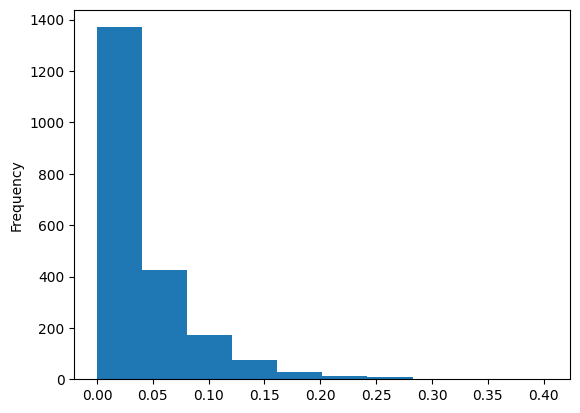

In [43]:
station_history.mean().plot(kind='hist')

<AxesSubplot: ylabel='Frequency'>

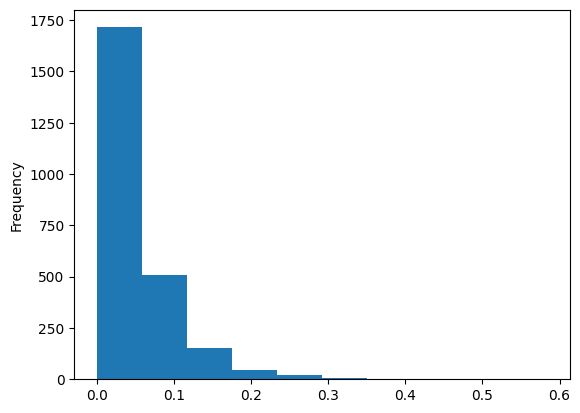

In [44]:
df.mean(axis=1).plot(kind='hist', bins=10)

### time-context features

In [45]:
TIME_IDX = pd.date_range('2021-07-01', freq='10min', periods=(31+31+30)*24*6)
contexts = pd.Series(data=TIME_IDX, name='ts').to_frame()

#### 1)  time encoding

In [46]:
def add_time_features(df, dt_col):
    df['seconds'] = df[dt_col].dt.hour.multiply(3600) + df[dt_col].dt.minute.multiply(60)
    seconds_in_day = 24*60*60
    df['sin_time'] = df['seconds'].divide(seconds_in_day).multiply(2*np.pi).map(np.sin)
    df['cos_time'] = df['seconds'].divide(seconds_in_day).multiply(2*np.pi).map(np.cos)

    df['dow'] = df[dt_col].dt.dayofweek
    df['weekend'] = df.dow.isin([5,6]).astype(np.int64)

    del df['seconds'], df[dt_col]
    return None



In [47]:
TIME_IDX = pd.date_range('2021-07-01', freq='10min', periods=(31+31+30)*24*6)
contexts = pd.Series(data=TIME_IDX, name='ts').to_frame()

add_time_features(contexts, 'ts')

In [48]:
contexts

,sin_time,cos_time,dow,weekend
0,0.00,1.00,3,0
1,0.04,1.00,3,0
2,0.09,1.00,3,0
3,0.13,0.99,3,0
4,0.17,0.98,3,0
...,...,...,...,...
13243,-0.22,0.98,3,0
13244,-0.17,0.98,3,0
13245,-0.13,0.99,3,0
13246,-0.09,1.00,3,0


In [54]:
contexts.head()

,sin_time,cos_time,dow,weekend
0,0.00,1.00,3,0
1,0.04,1.00,3,0
2,0.09,1.00,3,0
3,0.13,0.99,3,0
4,0.17,0.98,3,0


<AxesSubplot: >

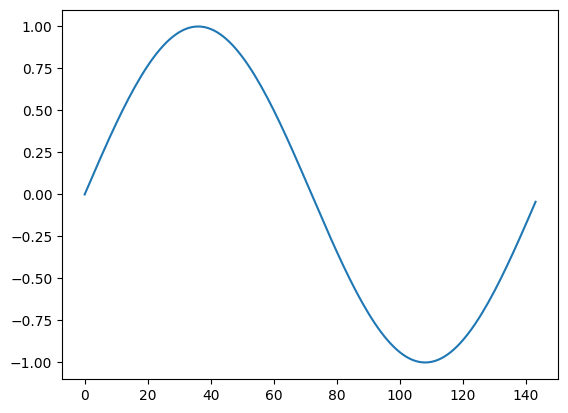

In [55]:
contexts.iloc[:144].sin_time.plot()

<AxesSubplot: >

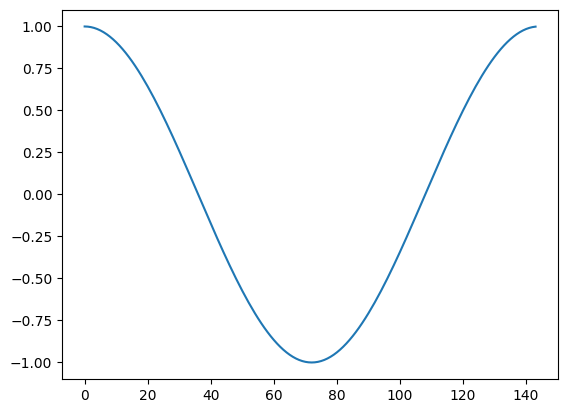

In [56]:
contexts.iloc[:144].cos_time.plot()